In [1]:
import numpy as np
import pandas as pd 
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

In [4]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [5]:
labels = dataset['train'].features['labels'].names

In [6]:
labels

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [7]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [8]:
id2label

{0: 'calling',
 1: 'clapping',
 2: 'cycling',
 3: 'dancing',
 4: 'drinking',
 5: 'eating',
 6: 'fighting',
 7: 'hugging',
 8: 'laughing',
 9: 'listening_to_music',
 10: 'running',
 11: 'sitting',
 12: 'sleeping',
 13: 'texting',
 14: 'using_laptop'}

In [9]:
id2label

{0: 'calling',
 1: 'clapping',
 2: 'cycling',
 3: 'dancing',
 4: 'drinking',
 5: 'eating',
 6: 'fighting',
 7: 'hugging',
 8: 'laughing',
 9: 'listening_to_music',
 10: 'running',
 11: 'sitting',
 12: 'sleeping',
 13: 'texting',
 14: 'using_laptop'}

In [10]:
from transformers import AutoImageProcessor
model_ckpt = "google/vit-base-patch16-224-in21k"
#model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

In [11]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

In [12]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size else (image_processor.size['height'], image_processor.size['width']))

In [14]:
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [15]:
def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]
    del batch['image']
    return batch

In [16]:
dataset = dataset.with_transform(transforms)

In [17]:
%pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [18]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
args = TrainingArguments(
    output_dir='train_dir',
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=image_processor
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.987600,1.339990,0.720238
2,1.231600,1.061653,0.746825
3,0.989200,0.947046,0.757937
4,0.817600,0.903578,0.765873
5,0.770600,0.852050,0.776984


TrainOutput(global_step=3150, training_loss=1.0965038045247395, metrics={'train_runtime': 1209.5534, 'train_samples_per_second': 41.668, 'train_steps_per_second': 2.604, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.0965038045247395, 'epoch': 5.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.8714157938957214,
 'eval_accuracy': 0.7761904761904762,
 'eval_runtime': 20.2031,
 'eval_samples_per_second': 124.733,
 'eval_steps_per_second': 7.821,
 'epoch': 5.0}

In [25]:
trainer.save_model('vit-human-pose-classification')

In [26]:
import shutil

# Define the training directory and output zip file
train_dir = "vit-human-pose-classification"  # Replace with your actual training directory path
output_zip = "vit-human-pose-classification.zip"

# Create a zip file of the training directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=train_dir)

output_zip

'vit-human-pose-classification.zip'

In [27]:
import shutil

# Define the training directory and output zip file
train_dir = "train_dir"  # Replace with your actual training directory path
output_zip = "train_dir.zip"

# Create a zip file of the training directory
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=train_dir)

output_zip

'train_dir.zip'

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
logits = trainer.predict(dataset['test'])

In [39]:
logits

PredictionOutput(predictions=array([[-0.36067674, -0.45081326, -0.13598554, ..., -0.8834459 ,
         0.10522716, -0.35764772],
       [ 0.08543608, -0.35590225, -0.23691447, ..., -0.380479  ,
        -0.19956672, -0.33243367],
       [-0.766429  ,  1.9175134 , -0.2987404 , ..., -0.53857625,
        -0.924078  , -0.62882835],
       ...,
       [-0.17755547, -0.36854315,  0.71006215, ...,  0.0349819 ,
        -0.25104418, -0.52071846],
       [ 0.328961  ,  0.3875214 , -0.89255595, ..., -0.48819536,
        -0.18755604, -0.29178935],
       [ 1.4278389 ,  0.07719024, -0.74769074, ..., -0.14752218,
        -0.03326418,  3.077651  ]], dtype=float32), label_ids=array([ 3,  4,  1, ..., 12, 12, 14]), metrics={'test_loss': 0.8789132237434387, 'test_accuracy': 0.7702380952380953, 'test_runtime': 19.767, 'test_samples_per_second': 127.485, 'test_steps_per_second': 7.993})

In [40]:
logits = logits.predictions

In [41]:
y_pred = np.argmax(logits, axis = 1)

In [42]:
y_pred

array([10,  9,  3, ...,  6,  8, 14])

In [49]:
y_true = [x['labels'] for x in dataset['test']]

In [51]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       170
           1       0.82      0.77      0.80       168
           2       0.91      0.96      0.94       168
           3       0.85      0.80      0.82       165
           4       0.86      0.81      0.83       168
           5       0.83      0.89      0.86       170
           6       0.80      0.90      0.85       179
           7       0.78      0.80      0.79       184
           8       0.74      0.77      0.75       148
           9       0.73      0.63      0.68       159
          10       0.82      0.89      0.85       146
          11       0.59      0.54      0.57       180
          12       0.84      0.82      0.83       158
          13       0.65      0.64      0.65       177
          14       0.70      0.74      0.72       180

    accuracy                           0.77      2520
   macro avg       0.77      0.77      0.77      2520
weighted avg       0.77   

In [52]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.63      0.61      0.62       170
          clapping       0.82      0.77      0.80       168
           cycling       0.91      0.96      0.94       168
           dancing       0.85      0.80      0.82       165
          drinking       0.86      0.81      0.83       168
            eating       0.83      0.89      0.86       170
          fighting       0.80      0.90      0.85       179
           hugging       0.78      0.80      0.79       184
          laughing       0.74      0.77      0.75       148
listening_to_music       0.73      0.63      0.68       159
           running       0.82      0.89      0.85       146
           sitting       0.59      0.54      0.57       180
          sleeping       0.84      0.82      0.83       158
           texting       0.65      0.64      0.65       177
      using_laptop       0.70      0.74      0.72       180

          accuracy                    

<Axes: >

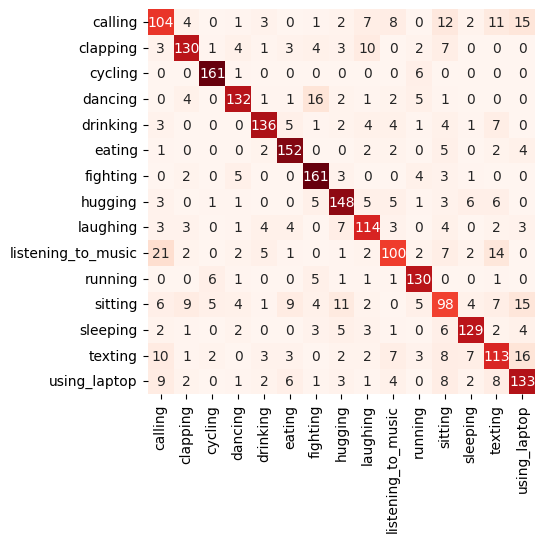

In [56]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')

In [57]:
from transformers import pipeline, AutoImageProcessor

In [58]:
pipe = pipeline('image-classification', model='vit-human-pose-classification',image_processor=image_processor)

Device set to use cuda:0


In [59]:
url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

In [61]:
output = pipe(url)

In [62]:
output

[{'label': 'sitting', 'score': 0.9498985409736633},
 {'label': 'using_laptop', 'score': 0.6536830067634583},
 {'label': 'running', 'score': 0.612960934638977},
 {'label': 'sleeping', 'score': 0.5530687570571899},
 {'label': 'texting', 'score': 0.5404998660087585}]